#import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD

# 시계열 데이터 생성

In [2]:
# 임의의 배열
x = np.array([100,200,300,400, 500, 600])
y = np.array([1,2,3,4,5,6])
cond = ([True, False, True, False, True, False])

# 조건에 따라 x 또는 y 선택
np.where(cond, x, y)  # cond가 True면 x, False면 y

# 랜덤 시드
np.random.seed(2000)

# 날짜 수: 12개월 * 30일 = 360일 + 시작점 포함 → 361개
days = 30 * 12
t = np.arange(days + 1)

# 시계열 구성 요소
trend = t * 0.05  # 점점 증가하는 추세
seasonality = 10 * np.sin(2 * np.pi * t / 30)  # 월 단위 주기성
noise = np.random.normal(0, 2, size=len(t))  # 평균 0, 표준편차 2의 잡음

# 최종 시계열
time_series = trend + seasonality + noise

#초반 데이터 시각화

array([ 3.47347522,  5.92494472, -0.04618041,  5.73002834,  8.79757136,
        4.39178797, 10.08504425,  8.8927925 ,  9.1036588 ,  9.00132565])

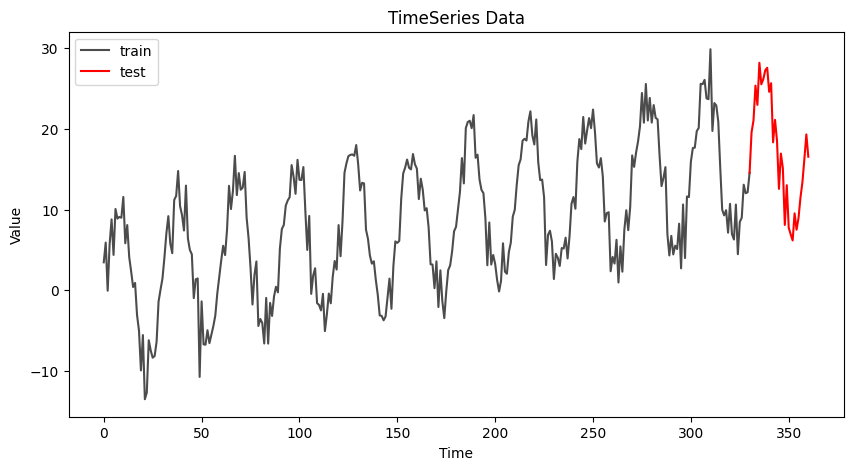

In [3]:
plt.figure(figsize=(10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color='black', alpha=0.7, label='train')  # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color='red', label='test')  # 테스트용 데이터
plt.legend()

time_series[0:10]


# Sequence 생성(전처리)

In [6]:
def sequence(time_series, n):
    x_train, y_train = list(), list()   # 입력과 출력을 저장할 리스트

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]  # 길이 n짜리 시퀀스 추출

        if (i + n) < len(time_series):  # 다음 값이 존재할 경우에만
            x_train.append(x)                 # 입력 시퀀스 추가
            y_train.append(time_series[i + n])  # 다음 시점 값 추가
        else:
            break  # 마지막에 도달하면 중지

    return np.array(x_train), np.array(y_train)  # numpy 배열로 반환

n = 20 # 시계열 데이터를 n크기의 슬라이딩 윈도우로 나눔
x_train, y_train = sequence(time_series, n)
x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

print("x_train :", x_train.shape)
print("y_train :", y_train.shape)

x_train : (341, 20, 1)
y_train : (341, 1)


#데이터 분리

In [9]:
partial_x_train = x_train[:30 * 10]
partial_y_train = y_train[:30 * 10]
x_test = x_train[30 * 10:]
y_test = y_train[30 * 10:]

print('train:', partial_x_train.shape, partial_y_train.shape)
print('test:', x_test.shape, y_test.shape)

# 생성 확인
test_arr = np.arange(100)
a, b = sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i], '|', b[i])

train: (300, 20, 1) (300, 1)
test: (41, 20, 1) (41, 1)
[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


#RNN 구축

In [14]:
model = Sequential()
model.add(SimpleRNN(units=32, activation='tanh', input_shape=(n, 1)))  # RNN 층 추가
model.add(Dense(1, activation='linear'))  # 출력층

model.compile(optimizer='adam', loss='mse')  # 모델 컴파일
model.summary()
model.fit(x_train, y_train, epochs=40, batch_size=1) # 학습

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 100.1021
Epoch 2/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.7352
Epoch 3/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.2449
Epoch 4/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.1170
Epoch 5/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.3013
Epoch 6/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.4076
Epoch 7/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.0690
Epoch 8/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9614
Epoch 9/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.4112
Epoch 10/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2906
Epoch 11/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0172
Epoch 12/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2251
Epoch 13/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9346
Epoch 14/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6179
Epoch 15/40
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

#결과 시각화(RNN)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


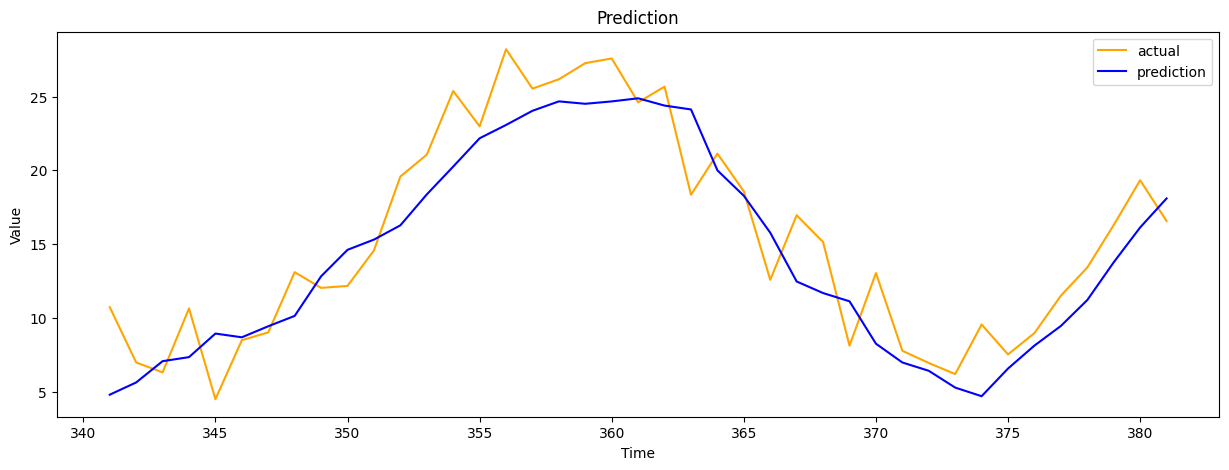

In [17]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15, 5))
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

# LSTM 구축

In [15]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, activation='tanh', input_shape=(n, 1), return_sequences=True)) # LSTM 1층 추가
LSTM_model.add(LSTM(units=50, activation='tanh')) # LSTM 2층 추가
LSTM_model.add(Dense(1, activation='linear')) # 출력층

LSTM_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mse') # 모델 컴파일
LSTM_model.summary()
LSTM_model.fit(x_train, y_train, epochs=70, batch_size=150)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 139.5608
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 65.0583
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 50.0249 
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 35.8453 
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.3526 
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 22.5897
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 28.8085 
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.7967
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 21.5537
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.1650
Epoch 11/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22.8307
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 17.8042
Epoch 13/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.3862
Epoch 14/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.5915
Epoch 15/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.3009
Epoch 16/70
3/

# 결과 시각화(LSTM)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


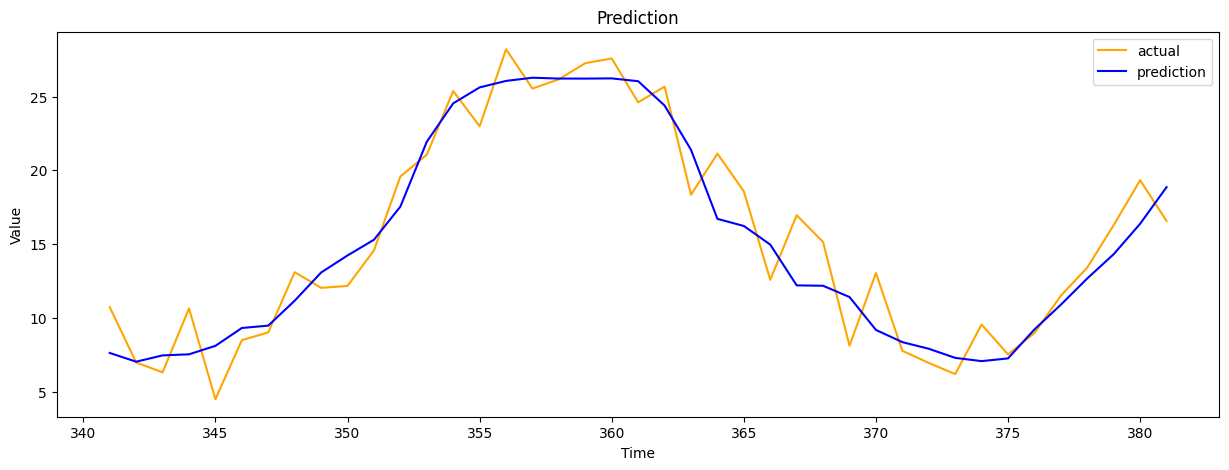

In [16]:
pred = LSTM_model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15, 5))
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()